In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect("database.sqlite")

tables = ['Country', 'League', 'Match', 'Player', 'Player_Attributes', 'Team', 'Team_Attributes']

df_country = pd.read_sql_query("SELECT * FROM Country", conn)
df_league = pd.read_sql_query("SELECT * FROM League", conn)
df_match = pd.read_sql_query("SELECT * FROM Match", conn)
df_player = pd.read_sql_query("SELECT * FROM Player", conn)
df_player_attributes = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)
df_team = pd.read_sql_query("SELECT * FROM Team", conn)
df_team_attributes = pd.read_sql_query("SELECT * FROM Team_Attributes", conn)

conn.close()

In [2]:
import pandas as pd

merged_df = pd.merge(df_team, df_match, left_on='team_api_id', right_on='home_team_api_id', how='inner')

final_df = pd.merge(merged_df, df_league, left_on='league_id', right_on='id', how='inner')

df_team_league_country = final_df[['team_long_name', 'team_api_id', 'name', 'id_x', 'country_id_y']].drop_duplicates()

df_team_league_country.columns = ['team_name', 'team_api_id', 'league_name', 'league_id', 'country_id']

df_team_league_country = pd.merge(df_team_league_country, df_country, left_on='country_id', right_on='id', how='left')

df_team_league_country = df_team_league_country[['team_name', 'team_api_id', 'league_name', 'league_id', 'name', 'country_id']]
df_team_league_country.columns = ['team_name', 'team_api_id', 'league_name', 'league_id', 'country_name', 'country_id']

df_team_league_country = df_team_league_country.sort_values(['country_name', 'league_name', 'team_name'])

df_team_league_country.to_csv('team_league_country_with_ids.csv', index=False)
teams = pd.merge(df_team_attributes,df_team, on='team_fifa_api_id', how='inner')  # Inner join
teams = pd.merge(teams, df_team_league_country, 
                     left_on='team_api_id_x', 
                     right_on='team_api_id', 
                     how='left')

print(teams.shape)
teams = teams[teams['country_id'].isin([1729,4769,7809,10257,21518])]
print(teams.shape)

teams['date'] = pd.to_datetime(teams['date'])

def get_filter_year():
    year = pd.to_datetime('2010-01-01')
    return year

def aggregate_numeric(x):
    return x.mean()

def aggregate_categorical(x):
    return x.mode().iloc[0]

filter_year = get_filter_year()

filtered_players = teams[teams['date'] >= filter_year]

numeric_columns = filtered_players.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = filtered_players.select_dtypes(include=['object']).columns

columns_to_aggregate = [col for col in filtered_players.columns if col not in ['date', 'year']]

aggregated_players = filtered_players.groupby('team_fifa_api_id').agg({
    **{col: aggregate_numeric for col in numeric_columns if col in columns_to_aggregate},
    **{col: aggregate_categorical for col in categorical_columns if col in columns_to_aggregate}
})



teams = aggregated_players
teams.set_index('team_api_id_x', inplace=True)
print(f"Filtered and aggregated data for players from {filter_year} onwards:")
print(teams.head())
print(f"\nShape of the aggregated data: {aggregated_players.shape}")


has_nan = teams.isnull().values.any()
print(f"Does teams contain NaN values? {has_nan}")

nan_count = teams.isnull().sum()
print("NaN count in each column:")
print(nan_count)

(1473, 35)
(924, 35)
Filtered and aggregated data for players from 2010-01-01 00:00:00 onwards:
                id_x  team_fifa_api_id  buildUpPlaySpeed  \
team_api_id_x                                              
9825.0          73.5               1.0         52.333333   
10252.0         79.5               2.0         65.666667   
8655.0         175.5               3.0         52.500000   
8559.0         200.5               4.0         54.666667   
8455.0         309.5               5.0         61.666667   

               buildUpPlayDribbling  buildUpPlayPassing  \
team_api_id_x                                             
9825.0                         51.0           31.166667   
10252.0                        34.5           58.666667   
8655.0                         45.5           63.833333   
8559.0                         35.5           63.833333   
8455.0                         46.5           45.000000   

               chanceCreationPassing  chanceCreationCrossing  \
team_

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_match_filtered = df_match[df_match['date'] > '2010-01-01']

df_combined = df_match_filtered.merge(df_league, left_on='league_id', right_on='id', suffixes=('', '_league'))
df_combined = df_combined.merge(df_country, left_on='country_id', right_on='id', suffixes=('', '_country'))

df_combined = df_combined.merge(df_team, left_on='home_team_api_id', right_on='team_api_id', suffixes=('', '_home_team'))
df_combined = df_combined.merge(df_team, left_on='away_team_api_id', right_on='team_api_id', suffixes=('', '_away_team'))

df_player_attributes['date'] = pd.to_datetime(df_player_attributes['date'])
df_combined['date'] = pd.to_datetime(df_combined['date'])

def get_team_avg_attributes(team_id, match_date):
    team_players = df_player_attributes[
        (df_player_attributes['date'] <= match_date) & 
        (df_player_attributes['player_api_id'].isin(df_combined[df_combined['home_team_api_id'] == team_id]['home_player_1'].unique()))
    ]
    team_players = team_players.sort_values('date').groupby('player_api_id').last()
    return team_players[['overall_rating', 'potential']].mean()

df_combined['home_team_avg_rating'] = df_combined.apply(lambda row: get_team_avg_attributes(row['home_team_api_id'], row['date'])['overall_rating'], axis=1)
df_combined['home_team_avg_potential'] = df_combined.apply(lambda row: get_team_avg_attributes(row['home_team_api_id'], row['date'])['potential'], axis=1)
df_combined['away_team_avg_rating'] = df_combined.apply(lambda row: get_team_avg_attributes(row['away_team_api_id'], row['date'])['overall_rating'], axis=1)
df_combined['away_team_avg_potential'] = df_combined.apply(lambda row: get_team_avg_attributes(row['away_team_api_id'], row['date'])['potential'], axis=1)

df_combined['match_outcome'] = df_combined.apply(lambda row: 1 if row['home_team_goal'] > row['away_team_goal'] else (0 if row['home_team_goal'] == row['away_team_goal'] else -1), axis=1)

attributes = ['buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', 
              'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', 
              'defencePressure', 'defenceAggression', 'defenceTeamWidth',
              'buildUpPlaySpeedClass', 'buildUpPlayDribblingClass',
              'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
              'chanceCreationPassingClass', 'chanceCreationCrossingClass',
              'chanceCreationShootingClass', 'chanceCreationPositioningClass',
              'defencePressureClass', 'defenceAggressionClass',
              'defenceTeamWidthClass', 'defenceDefenderLineClass']

for attr in attributes:
    df_combined[f'home_{attr}'] = df_combined['home_team_api_id'].map(teams[attr])
    df_combined[f'away_{attr}'] = df_combined['away_team_api_id'].map(teams[attr])

categorical_columns = ['buildUpPlaySpeedClass', 'buildUpPlayDribblingClass', 'buildUpPlayPassingClass',
                       'buildUpPlayPositioningClass', 'chanceCreationPassingClass', 'chanceCreationCrossingClass', 
                       'chanceCreationShootingClass', 'chanceCreationPositioningClass', 'defencePressureClass',
                       'defenceAggressionClass', 'defenceTeamWidthClass', 'defenceDefenderLineClass']

def one_hot_encode_column(column):
    unique_values = column.unique()
    return column.apply(lambda x: list(unique_values).index(x))

for col in categorical_columns:
    df_combined[f'home_{col}'] = one_hot_encode_column(df_combined[f'home_{col}'])
    df_combined[f'away_{col}'] = one_hot_encode_column(df_combined[f'away_{col}'])
features_for_correlation = [
    'home_team_avg_rating', 'home_team_avg_potential',
    'away_team_avg_rating', 'away_team_avg_potential',
    'home_team_goal', 'away_team_goal', 'match_outcome'
]

for attr in attributes:
    features_for_correlation.append(f'home_{attr}')
    features_for_correlation.append(f'away_{attr}')

print(features_for_correlation)
df_combined.head()

['home_team_avg_rating', 'home_team_avg_potential', 'away_team_avg_rating', 'away_team_avg_potential', 'home_team_goal', 'away_team_goal', 'match_outcome', 'home_buildUpPlaySpeed', 'away_buildUpPlaySpeed', 'home_buildUpPlayDribbling', 'away_buildUpPlayDribbling', 'home_buildUpPlayPassing', 'away_buildUpPlayPassing', 'home_chanceCreationPassing', 'away_chanceCreationPassing', 'home_chanceCreationCrossing', 'away_chanceCreationCrossing', 'home_chanceCreationShooting', 'away_chanceCreationShooting', 'home_defencePressure', 'away_defencePressure', 'home_defenceAggression', 'away_defenceAggression', 'home_defenceTeamWidth', 'away_defenceTeamWidth', 'home_buildUpPlaySpeedClass', 'away_buildUpPlaySpeedClass', 'home_buildUpPlayDribblingClass', 'away_buildUpPlayDribblingClass', 'home_buildUpPlayPassingClass', 'away_buildUpPlayPassingClass', 'home_buildUpPlayPositioningClass', 'away_buildUpPlayPositioningClass', 'home_chanceCreationPassingClass', 'away_chanceCreationPassingClass', 'home_chanceCr

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,home_chanceCreationPositioningClass,away_chanceCreationPositioningClass,home_defencePressureClass,away_defencePressureClass,home_defenceAggressionClass,away_defenceAggressionClass,home_defenceTeamWidthClass,away_defenceTeamWidthClass,home_defenceDefenderLineClass,away_defenceDefenderLineClass
0,377,1,1,2009/2010,19,2010-02-03,665626,8635,8342,3,...,0,0,0,0,0,0,0,0,0,0
1,379,1,1,2009/2010,19,2010-02-04,665630,9986,9985,2,...,0,0,0,0,0,0,0,0,0,0
2,382,1,1,2009/2010,19,2010-02-02,665634,8203,9993,1,...,0,0,0,0,0,0,0,0,0,0
3,405,1,1,2009/2010,22,2010-01-30,665665,8342,10001,2,...,0,0,0,0,0,0,0,0,0,0
4,406,1,1,2009/2010,22,2010-01-17,665666,9985,8635,0,...,0,0,0,0,0,0,0,0,0,0


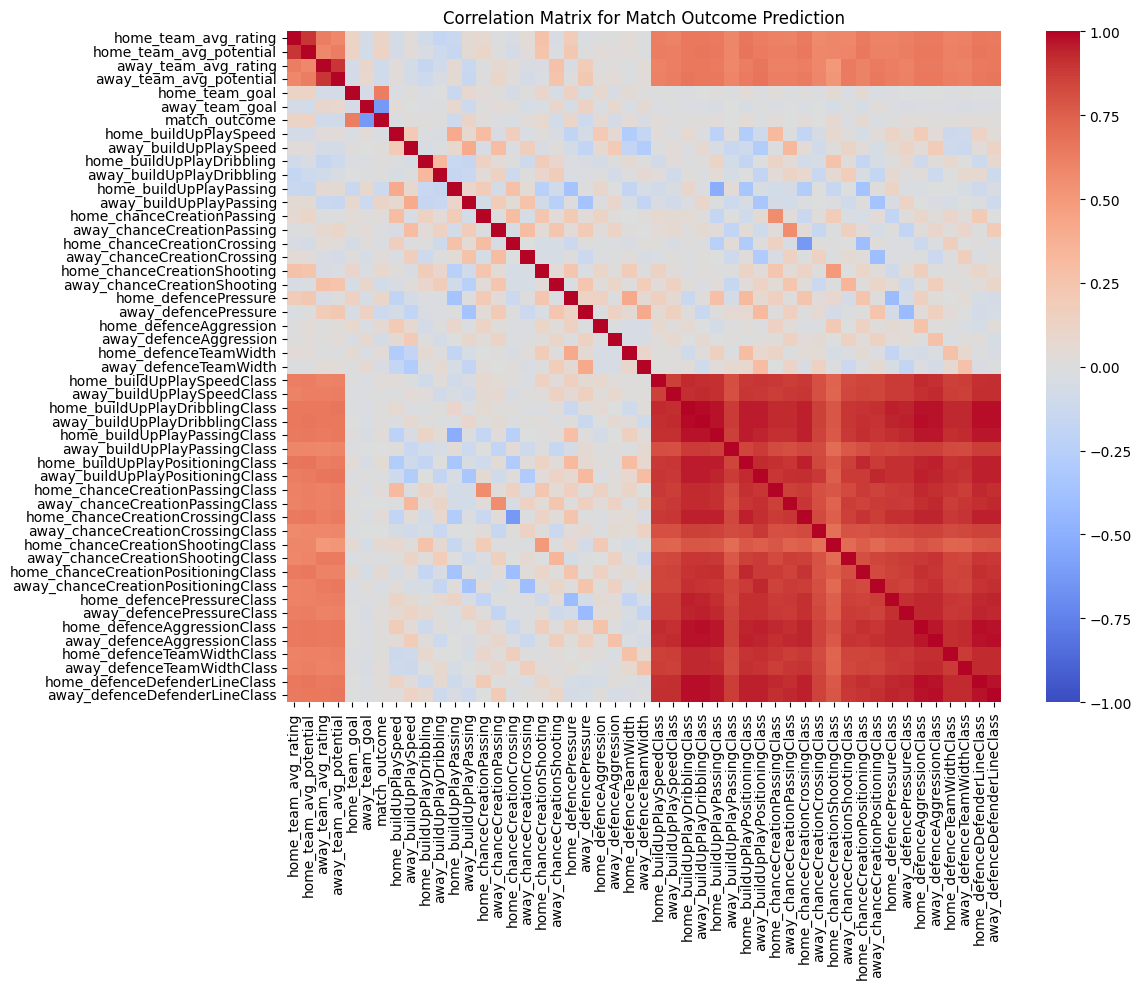

match_outcome                          1.000000
home_team_goal                         0.626126
home_team_avg_potential                0.125314
home_team_avg_rating                   0.112424
away_buildUpPlayPassing                0.111684
home_defencePressure                   0.105439
home_chanceCreationShooting            0.072100
home_chanceCreationShootingClass       0.058646
home_defenceAggression                 0.057516
home_chanceCreationPositioningClass    0.051384
home_buildUpPlayPositioningClass       0.039500
home_defenceTeamWidth                  0.037717
home_chanceCreationPassingClass        0.028820
away_chanceCreationCrossing            0.028555
home_buildUpPlayPassingClass           0.025682
away_defencePressureClass              0.025029
away_defenceTeamWidthClass             0.024605
home_buildUpPlaySpeedClass             0.024179
home_chanceCreationCrossingClass       0.023907
home_chanceCreationPassing             0.022591
home_defenceDefenderLineClass          0

In [4]:

correlation_matrix = df_combined[features_for_correlation].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix for Match Outcome Prediction')
plt.tight_layout()
plt.show()

print(correlation_matrix['match_outcome'].sort_values(ascending=False))


In [5]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.neural_network import MLPClassifier


# features = [
#     'home_team_avg_rating', 'home_team_avg_potential',
#     'away_team_avg_rating', 'away_team_avg_potential'
# ]

# df_combined = df_combined.fillna(0)
# #print(df_combined.isnull().sum())

# X = df_combined[features]
# y = df_combined['match_outcome']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# models = {
#     'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
#     #'XGBoost': XGBClassifier(n_estimators=100, random_state=42),
#     'Neural Network': MLPClassifier(hidden_layer_sizes=(500, 100), max_iter=500, random_state=42)
# }

# results = {}

# for name, model in models.items():
#     model.fit(X_train_scaled, y_train)
    
#     y_pred = model.predict(X_test_scaled)
    
#     accuracy = accuracy_score(y_test, y_pred)
    
#     results[name] = {
#         'accuracy': accuracy,
#         'confusion_matrix': confusion_matrix(y_test, y_pred),
#         'classification_report': classification_report(y_test, y_pred, target_names=['Away Win', 'Draw', 'Home Win'], output_dict=True)
#     }
    
#     print(f"\n{name} Results:")
#     print(f"Accuracy: {accuracy:.4f}")
#     print("\nClassification Report:")
#     print(classification_report(y_test, y_pred, target_names=['Away Win', 'Draw', 'Home Win']))
#     print("\nConfusion Matrix:")
#     print(confusion_matrix(y_test, y_pred))

# plt.figure(figsize=(10, 6))
# accuracies = [results[model]['accuracy'] for model in models]
# plt.bar(models.keys(), accuracies)
# plt.title('Model Accuracy Comparison')
# plt.ylabel('Accuracy')
# plt.ylim(0, 1)
# for i, v in enumerate(accuracies):
#     plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
# plt.show()

# class_names = ['Away Win', 'Draw', 'Home Win']

# fig, axes = plt.subplots(1, 2, figsize=(20, 5))
# for i, (name, model) in enumerate(models.items()):
#     sns.heatmap(results[name]['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[i],
#                 xticklabels=class_names, yticklabels=class_names)
#     axes[i].set_title(f'{name} Confusion Matrix')
#     axes[i].set_xlabel('Predicted')
#     axes[i].set_ylabel('Actual')
# plt.tight_layout()
# plt.show()

# f1_scores = {name: results[name]['classification_report']['weighted avg']['f1-score'] for name in models}
# plt.figure(figsize=(10, 6))
# plt.bar(f1_scores.keys(), f1_scores.values())
# plt.title('Weighted Average F1-Score Comparison')
# plt.ylabel('F1-Score')
# plt.ylim(0, 1)
# for i, v in enumerate(f1_scores.values()):
#     plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
# plt.show()


Random Forest Results:
Accuracy: 0.4482
Classification Report:
              precision    recall  f1-score   support

    Away Win       0.41      0.38      0.39      1187
        Draw       0.26      0.17      0.21      1090
    Home Win       0.53      0.65      0.58      1935

    accuracy                           0.45      4212
   macro avg       0.40      0.40      0.39      4212
weighted avg       0.42      0.45      0.43      4212

Confusion Matrix:
[[ 446  219  522]
 [ 292  189  609]
 [ 359  323 1253]]

Gradient Boosting Results:
Accuracy: 0.5043
Classification Report:
              precision    recall  f1-score   support

    Away Win       0.49      0.35      0.41      1187
        Draw       0.29      0.03      0.05      1090
    Home Win       0.51      0.87      0.65      1935

    accuracy                           0.50      4212
   macro avg       0.43      0.42      0.37      4212
weighted avg       0.45      0.50      0.42      4212

Confusion Matrix:
[[ 418   32  73

Epoch [10/50], Loss: 1.0197, Training Accuracy: 0.4957


Epoch [20/50], Loss: 1.0185, Training Accuracy: 0.4964


Epoch [30/50], Loss: 1.0175, Training Accuracy: 0.4972


Epoch [40/50], Loss: 1.0152, Training Accuracy: 0.4963


/home/svrao3/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/svrao3/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/svrao3/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [50/50], Loss: 1.0155, Training Accuracy: 0.4986
PyTorch Neural Network Accuracy on test set: 0.5085

Neural Network Results:
Accuracy: 0.5085
Classification Report:
              precision    recall  f1-score   support

    Away Win       0.48      0.39      0.43      1187
        Draw       0.00      0.00      0.00      1090
    Home Win       0.52      0.87      0.65      1935

    accuracy                           0.51      4212
   macro avg       0.33      0.42      0.36      4212
weighted avg       0.37      0.51      0.42      4212

Confusion Matrix:
[[ 462    0  725]
 [ 255    0  835]
 [ 255    0 1680]]

Neural Network Results:
Accuracy: 0.5085
Classification Report:
              precision    recall  f1-score   support

    Away Win       0.48      0.39      0.43      1187
        Draw       0.00      0.00      0.00      1090
    Home Win       0.52      0.87      0.65      1935

    accuracy                           0.51      4212
   macro avg       0.33      0.42    

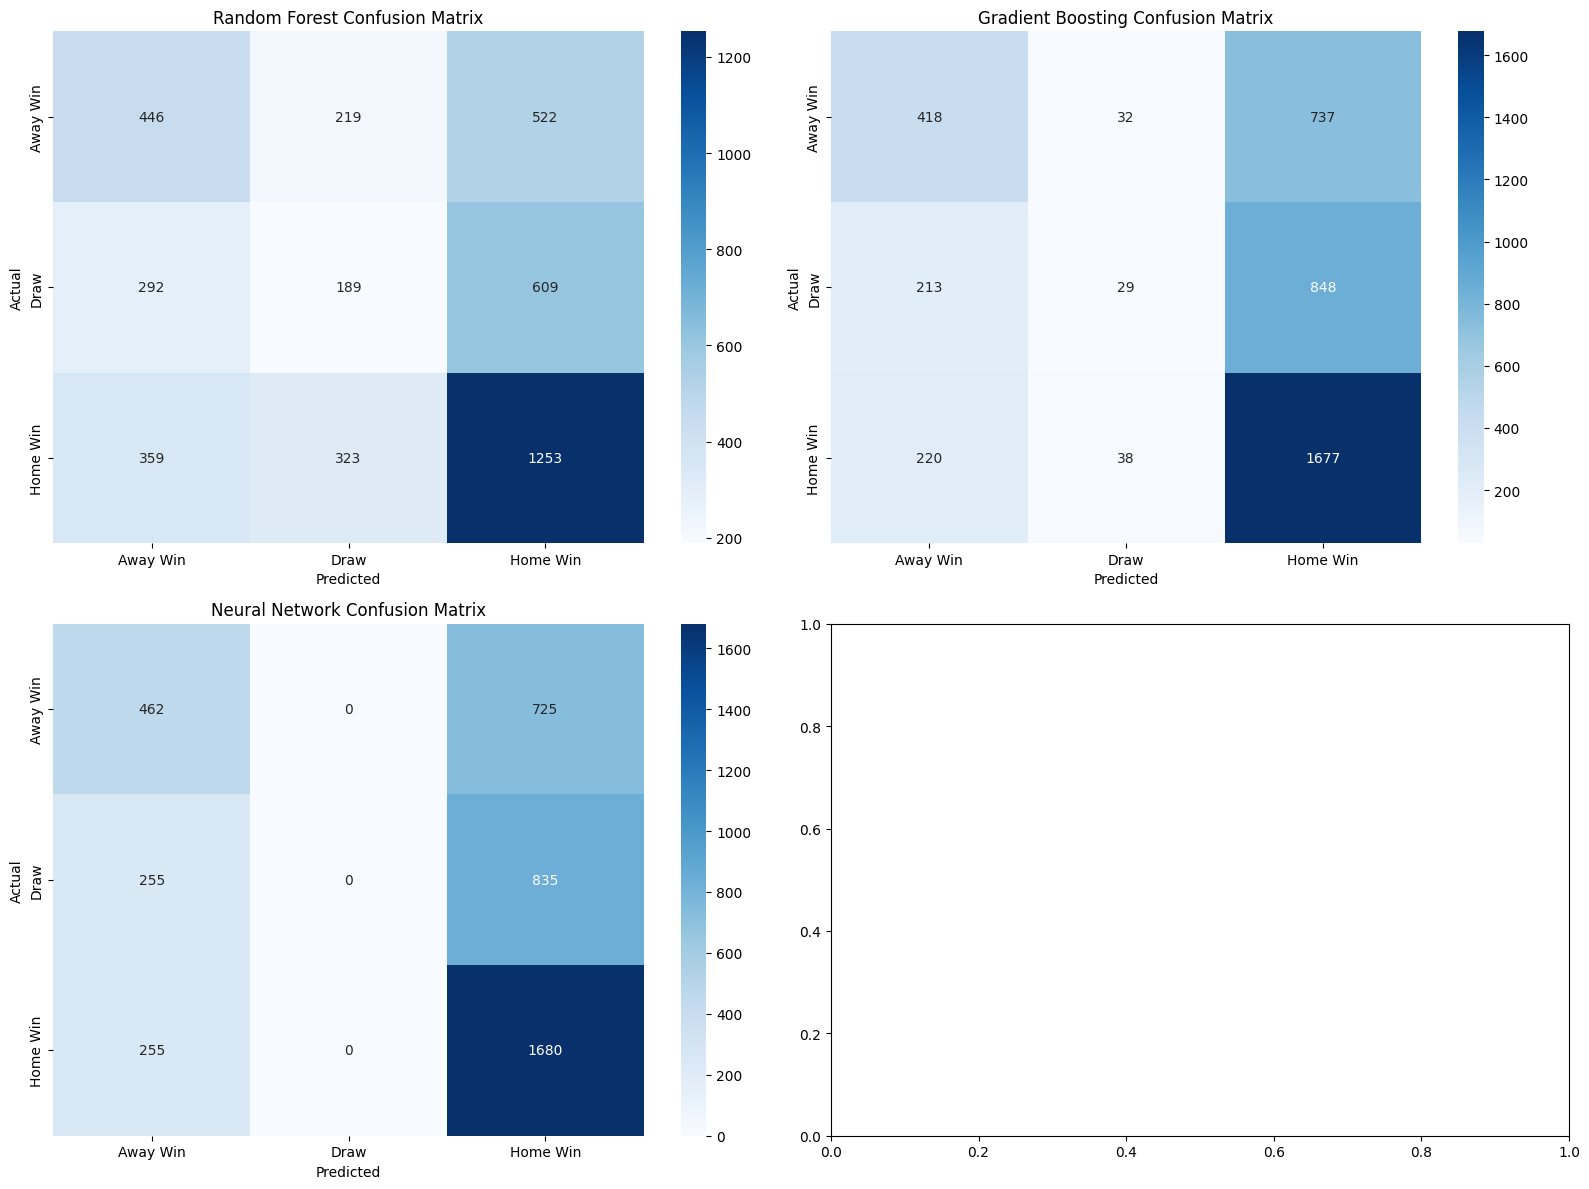

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()
    
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None

    def check(self, current_loss):
        if self.best_loss is None or (self.best_loss - current_loss) > self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
            return False  # Continue training
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True  # Stop training
            return False
        
# Neural network architecture (as defined previously)
class MatchOutcomeNN(nn.Module):
    def __init__(self, input_size):
        super(MatchOutcomeNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.fc5 = nn.Linear(32, 3)  # Output for 3 classes
        self.dropout = nn.Dropout(0.4)  # Reduced dropout rate to 0.2

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        #x = self.dropout(x)
        x = torch.relu(self.bn4(self.fc4(x)))
        #x = self.dropout(x)
        x = self.fc5(x)  # No softmax here since we'll use CrossEntropyLoss
        return x

def train_pytorch_nn(model, X_train, y_train, X_test, y_test, num_epochs=50, batch_size=32):
    y_train = y_train.replace({-1: 0, 1: 1, 0: 2})  # Replace labels for training data
    y_test = y_test.replace({-1: 0, 1: 1, 0: 2})  # Replace labels for test data
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)  # Convert to numpy array first
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)  # Convert to numpy array first
    
    #Create DataLoader for batching
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)  # Added L2 regularization
    scheduler = StepLR(optimizer, step_size=100, gamma=0.5)  # Reduce LR
    early_stopping = EarlyStopping(patience=20, min_delta=0.001)
    
    # Training loop with tqdm
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0  # Variable to count correct predictions during training
        total_samples = 0  # Variable to count total samples processed
        
        # Use tqdm to show a progress bar for batch processing
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate number of correct predictions
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            
            running_loss += loss.item()
        scheduler.step()
        
        # Calculate training accuracy for every 10 epochs
        if (epoch+1) % 10 == 0:
            train_accuracy = correct_predictions / total_samples
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Training Accuracy: {train_accuracy:.4f}')
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        
        # Map the predicted labels back to original encoding
        predicted_mapped = predicted.numpy()
        predicted_mapped = np.where(predicted_mapped == 0, -1, predicted_mapped)  # 0 -> -1 (Loss)
        predicted_mapped = np.where(predicted_mapped == 2, 0, predicted_mapped)  # 2 -> 0 (Draw)
        predicted_mapped = np.where(predicted_mapped == 1, 1, predicted_mapped)  # 1 -> 1 (Win)
        
        # Calculate accuracy
        accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
        print(f'PyTorch Neural Network Accuracy on test set: {accuracy:.4f}')
    
    return predicted_mapped, accuracy

# Data preparation
features = [
    'home_team_avg_rating', 'home_team_avg_potential',
    'away_team_avg_rating', 'away_team_avg_potential'
]
team_attr = [
    'buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', 
    'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', 
    'defencePressure', 'defenceAggression', 'defenceTeamWidth'
]
features.extend([f'home_{attr}' for attr in team_attr])
features.extend([f'away_{attr}' for attr in team_attr])

df_combined = df_combined.fillna(0)

X = df_combined[features]
y = df_combined['match_outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train individual models and get metrics
rf_model.fit(X_train_scaled, y_train)
rf_predictions = rf_model.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
rf_class_report = classification_report(y_test, rf_predictions, target_names=['Away Win', 'Draw', 'Home Win'])

print("\nRandom Forest Results:")
print(f"Accuracy: {rf_accuracy:.4f}")
print("Classification Report:")
print(rf_class_report)
print("Confusion Matrix:")
print(rf_conf_matrix)

gb_classifier.fit(X_train_scaled, y_train)
gb_predictions = gb_classifier.predict(X_test_scaled)
gb_accuracy = accuracy_score(y_test, gb_predictions)
gb_conf_matrix = confusion_matrix(y_test, gb_predictions)
gb_class_report = classification_report(y_test, gb_predictions, target_names=['Away Win', 'Draw', 'Home Win'])

print("\nGradient Boosting Results:")
print(f"Accuracy: {gb_accuracy:.4f}")
print("Classification Report:")
print(gb_class_report)
print("Confusion Matrix:")
print(gb_conf_matrix)

input_size = X_train_scaled.shape[1]
nn_model = MatchOutcomeNN(input_size)
nn_predictions, nn_probabilities = train_pytorch_nn(nn_model, X_train_scaled, y_train, X_test_scaled, y_test, num_epochs=50)

# Since predictions are already mapped, use them directly
nn_accuracy = accuracy_score(y_test, nn_predictions)
nn_conf_matrix = confusion_matrix(y_test, nn_predictions)
nn_class_report = classification_report(y_test, nn_predictions, target_names=['Away Win', 'Draw', 'Home Win'])

print("\nNeural Network Results:")
print(f"Accuracy: {nn_accuracy:.4f}")
print("Classification Report:")
print(nn_class_report)
print("Confusion Matrix:")
print(nn_conf_matrix)

print("\nNeural Network Results:")
print(f"Accuracy: {nn_accuracy:.4f}")
print("Classification Report:")
print(nn_class_report)
print("Confusion Matrix:")
print(nn_conf_matrix)

# Plot confusion matrices for each model
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
model_names = ["Random Forest", "Gradient Boosting", "Neural Network"]
conf_matrices = [rf_conf_matrix, gb_conf_matrix, nn_conf_matrix]

for i, (ax, conf_matrix, model_name) in enumerate(zip(axes.flatten(), conf_matrices, model_names)):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Away Win', 'Draw', 'Home Win'],
                yticklabels=['Away Win', 'Draw', 'Home Win'])
    ax.set_title(f'{model_name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()


Random Forest Results:
Accuracy: 0.4504
Classification Report:
              precision    recall  f1-score   support

    Away Win       0.41      0.38      0.39      1187
        Draw       0.27      0.18      0.21      1090
    Home Win       0.53      0.65      0.58      1935

    accuracy                           0.45      4212
   macro avg       0.40      0.40      0.40      4212
weighted avg       0.43      0.45      0.43      4212

Confusion Matrix:
[[ 450  208  529]
 [ 294  193  603]
 [ 360  321 1254]]

Gradient Boosting Results:
Accuracy: 0.4929
Classification Report:
              precision    recall  f1-score   support

    Away Win       0.47      0.38      0.42      1187
        Draw       0.26      0.08      0.12      1090
    Home Win       0.53      0.80      0.63      1935

    accuracy                           0.49      4212
   macro avg       0.42      0.42      0.39      4212
weighted avg       0.44      0.49      0.44      4212

Confusion Matrix:
[[ 450  103  63

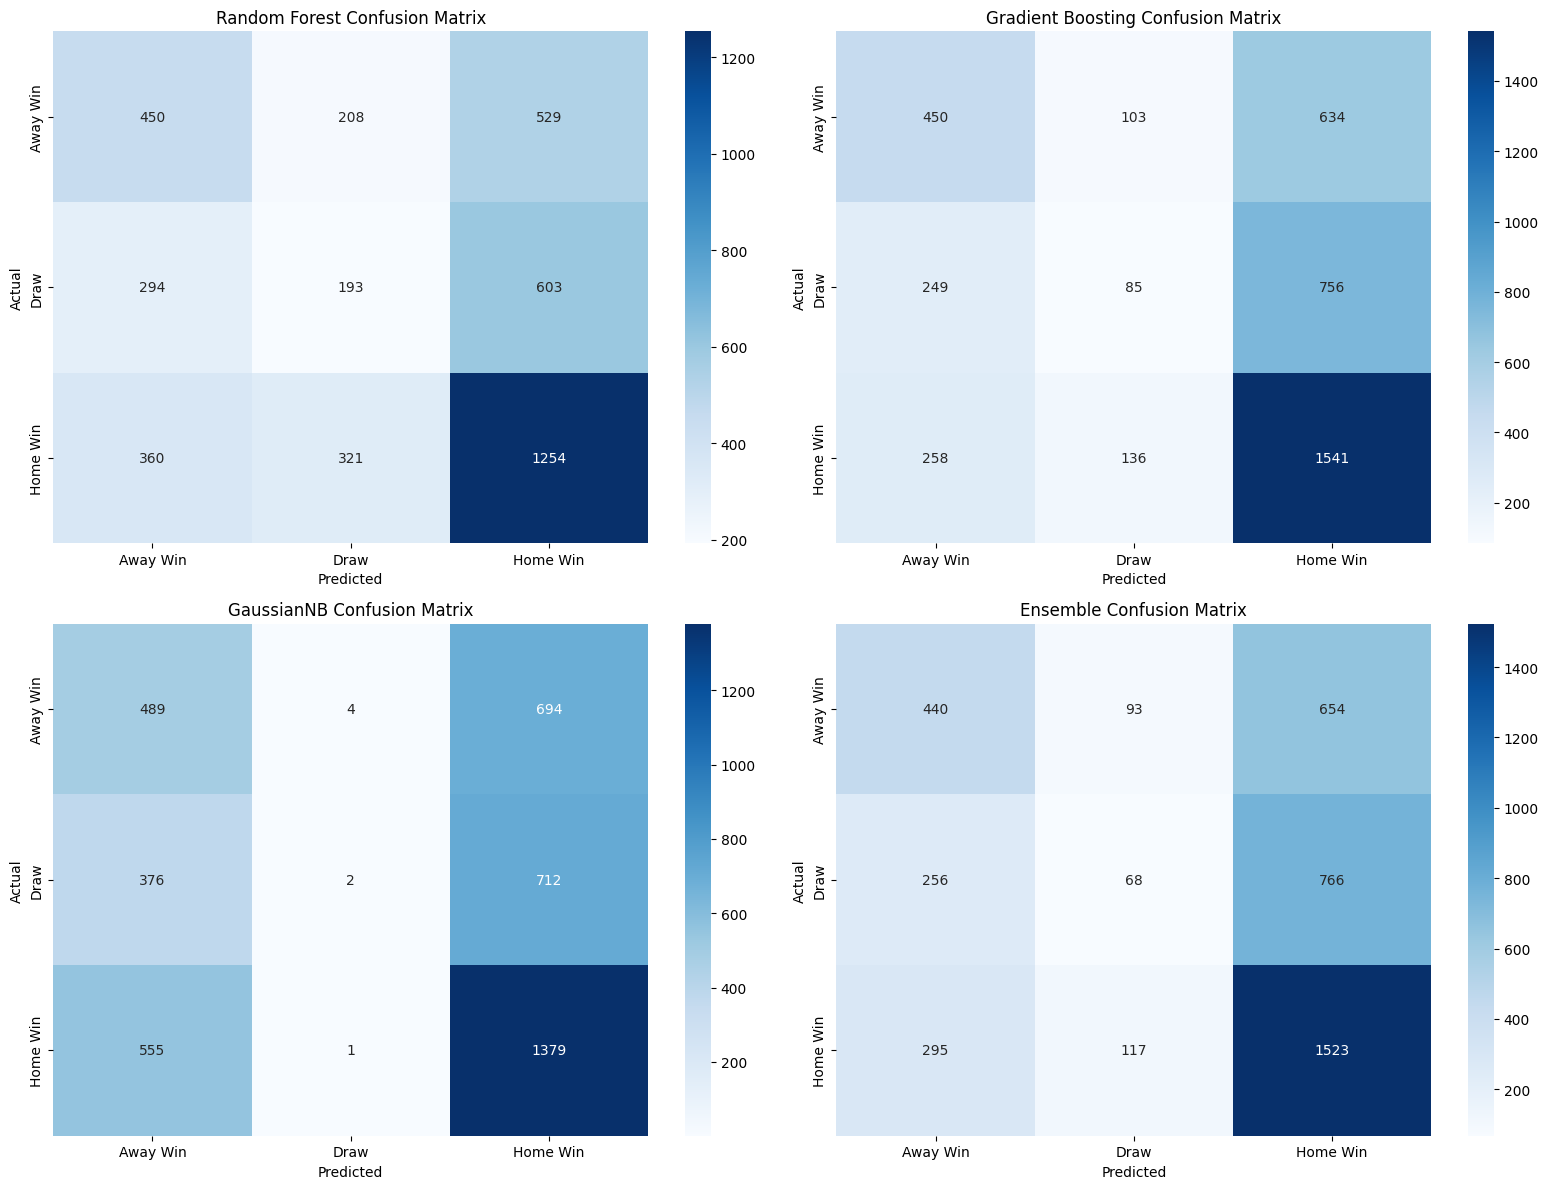

In [19]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
# Initialize individual models
rf_model = RandomForestClassifier(n_estimators=500, random_state=42, class_weight='balanced')
gb_classifier = GradientBoostingClassifier(n_estimators=500, random_state=42)
nb_model = GaussianNB()

# Ensemble model with majority voting
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('gb', gb_classifier),
        ('nb', nb_model)
    ],
    voting='soft'  # 'soft' for probability-based voting
)

# Fit and evaluate individual models
rf_model.fit(X_train_scaled, y_train)
gb_classifier.fit(X_train_scaled, y_train)
nb_model.fit(X_train_scaled, y_train)

# Predict and evaluate each model
def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)
    class_report = classification_report(y_test, predictions, target_names=['Away Win', 'Draw', 'Home Win'])
    
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(class_report)
    print("Confusion Matrix:")
    print(conf_matrix)
    return conf_matrix

# Random Forest evaluation
rf_conf_matrix = evaluate_model(rf_model, X_test_scaled, y_test, "Random Forest")

# Gradient Boosting evaluation
gb_conf_matrix = evaluate_model(gb_classifier, X_test_scaled, y_test, "Gradient Boosting")

# GaussianNB evaluation
nb_conf_matrix = evaluate_model(nb_model, X_test_scaled, y_test, "GaussianNB")

# Train and evaluate the ensemble model
ensemble_model.fit(X_train_scaled, y_train)
ensemble_predictions = ensemble_model.predict(X_test_scaled)
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_conf_matrix = confusion_matrix(y_test, ensemble_predictions)
ensemble_class_report = classification_report(y_test, ensemble_predictions, target_names=['Away Win', 'Draw', 'Home Win'])

print("\nEnsemble Model Results:")
print(f"Accuracy: {ensemble_accuracy:.4f}")
print("Classification Report:")
print(ensemble_class_report)
print("Confusion Matrix:")
print(ensemble_conf_matrix)

# Plot confusion matrices for each model and the ensemble
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
model_names = ["Random Forest", "Gradient Boosting", "GaussianNB", "Ensemble"]
conf_matrices = [rf_conf_matrix, gb_conf_matrix, nb_conf_matrix, ensemble_conf_matrix]

for ax, conf_matrix, model_name in zip(axes.flatten(), conf_matrices, model_names):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Away Win', 'Draw', 'Home Win'],
                yticklabels=['Away Win', 'Draw', 'Home Win'])
    ax.set_title(f'{model_name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()


SVM Results:
Accuracy: 0.4281
Classification Report:
              precision    recall  f1-score   support

    Away Win       0.44      0.44      0.44      1187
        Draw       0.27      0.43      0.33      1090
    Home Win       0.62      0.42      0.50      1935

    accuracy                           0.43      4212
   macro avg       0.44      0.43      0.42      4212
weighted avg       0.48      0.43      0.44      4212

Confusion Matrix:
[[518 455 214]
 [327 465 298]
 [342 773 820]]

Updated Ensemble Model Results:
Accuracy: 0.4929
Classification Report:
              precision    recall  f1-score   support

    Away Win       0.46      0.38      0.41      1187
        Draw       0.25      0.04      0.07      1090
    Home Win       0.52      0.82      0.63      1935

    accuracy                           0.49      4212
   macro avg       0.41      0.41      0.37      4212
weighted avg       0.43      0.49      0.43      4212

Confusion Matrix:
[[ 449   61  677]
 [ 250   46

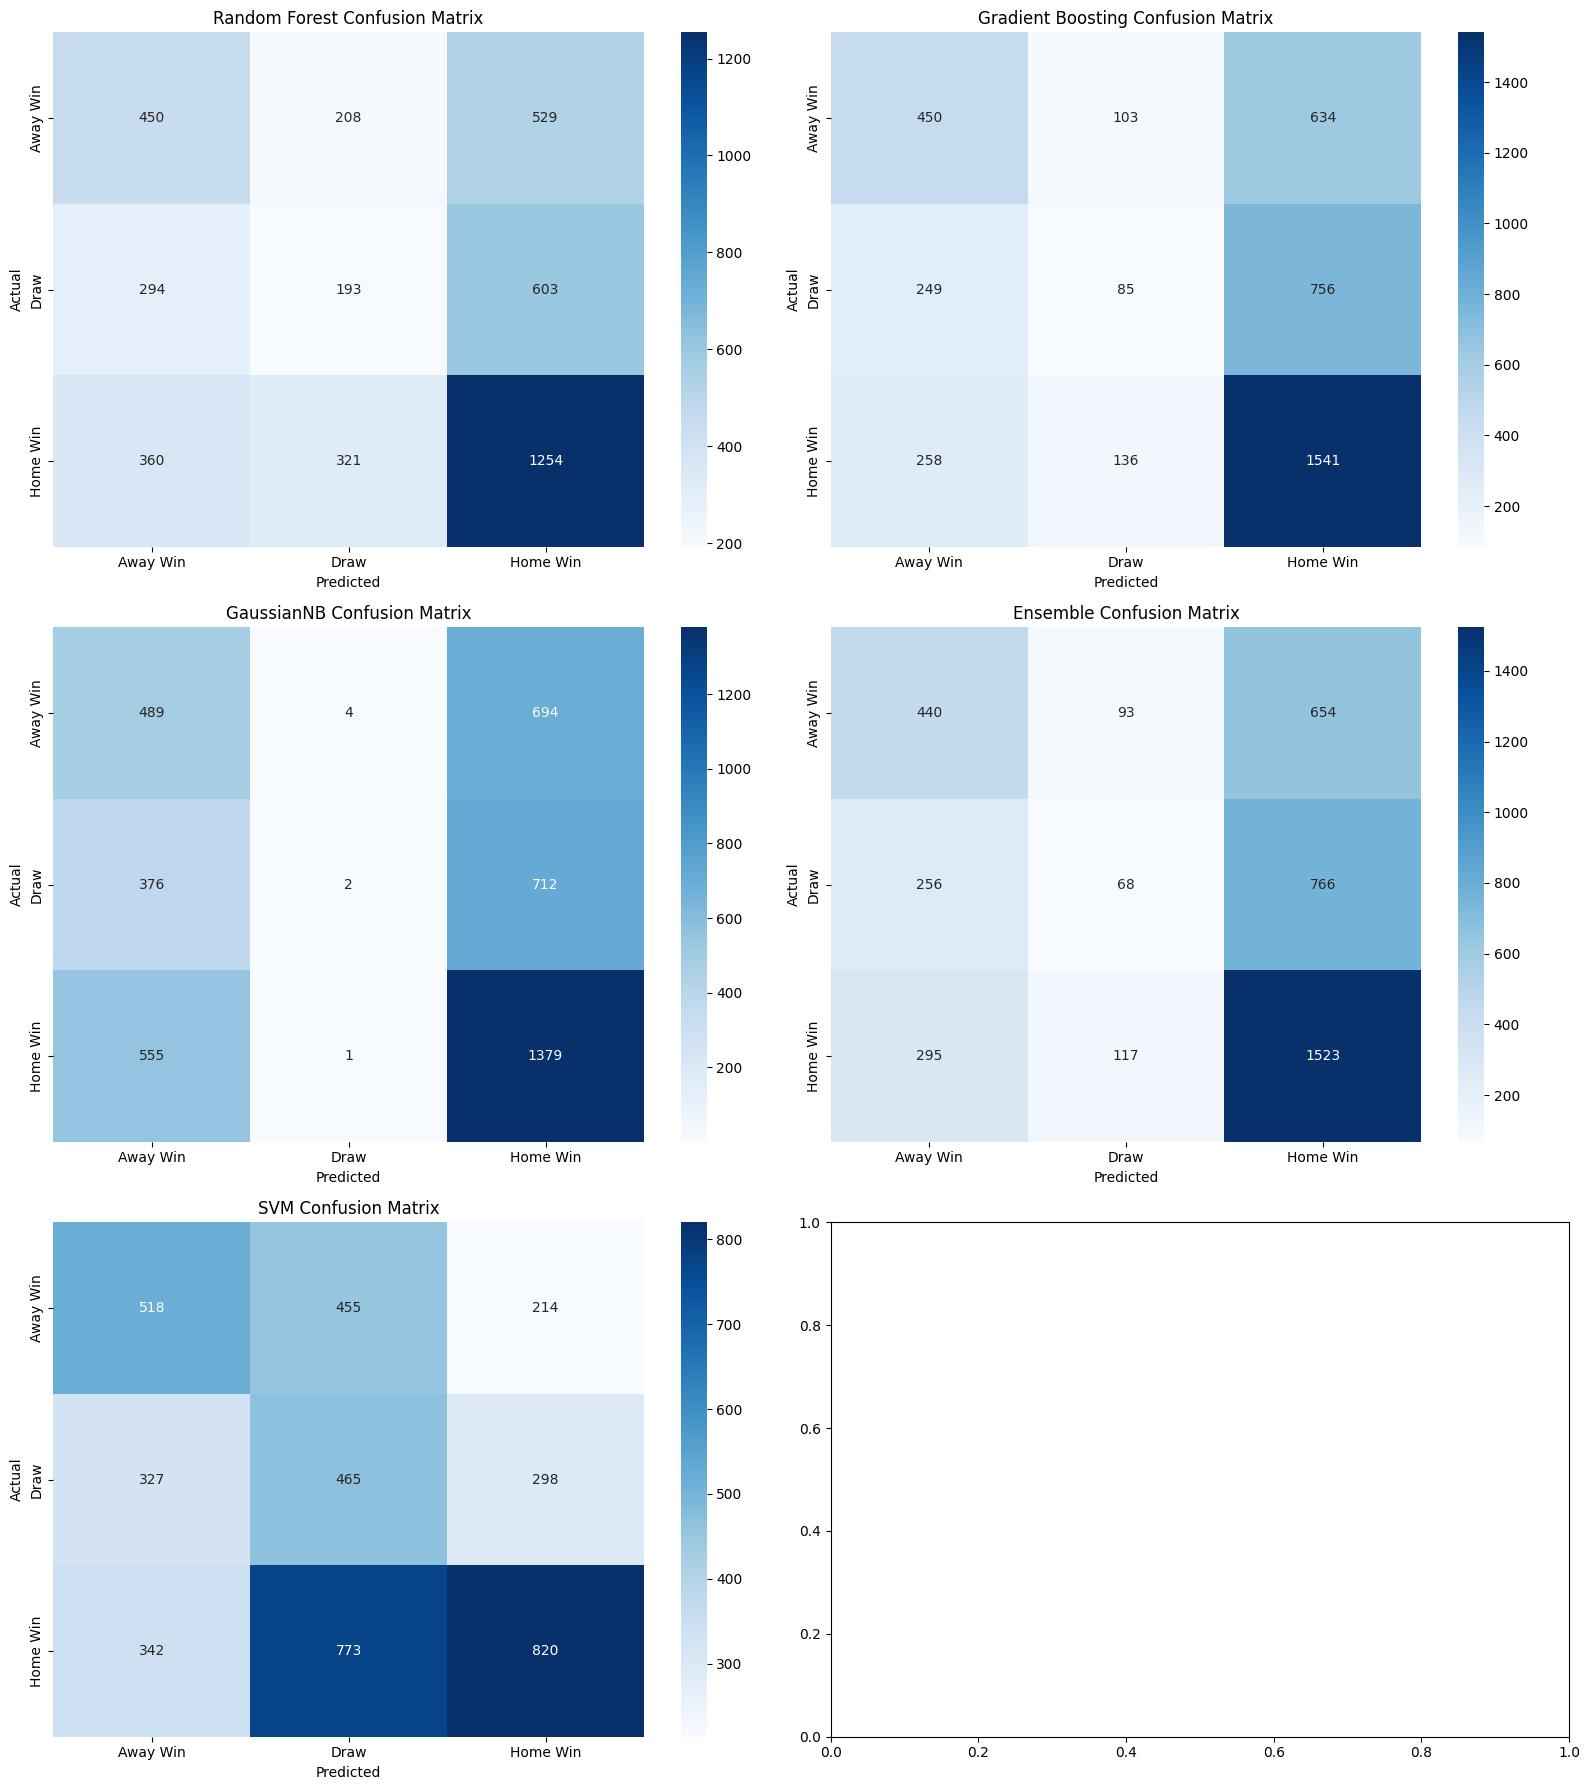

In [ ]:
from sklearn.svm import SVC

# Initialize SVM
svm_model = SVC(
    probability=True,  # Required for soft voting in VotingClassifier
    random_state=42,
    class_weight='balanced',  # Handles class imbalance
    kernel='rbf',  # Experiment with 'linear', 'poly', or 'sigmoid' if needed
    C=0.5,  # Lower regularization for better generalization
    gamma=0.1  # Explicit gamma setting for fine control
)
# Add SVM to the ensemble
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('gb', gb_classifier),
        ('nb', nb_model),
        ('svm', svm_model)
    ],
    voting='soft'  # 'soft' for probability-based voting
)

# Train and evaluate SVM separately
svm_model.fit(X_train_scaled, y_train)
svm_conf_matrix = evaluate_model(svm_model, X_test_scaled, y_test, "SVM")

# Train and evaluate the updated ensemble
ensemble_model.fit(X_train_scaled, y_train)
ensemble_predictions = ensemble_model.predict(X_test_scaled)
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_conf_matrix = confusion_matrix(y_test, ensemble_predictions)
ensemble_class_report = classification_report(y_test, ensemble_predictions, target_names=['Away Win', 'Draw', 'Home Win'])

print("\nUpdated Ensemble Model Results:")
print(f"Accuracy: {ensemble_accuracy:.4f}")
print("Classification Report:")
print(ensemble_class_report)
print("Confusion Matrix:")
print(ensemble_conf_matrix)

# Update Confusion Matrix Plot
conf_matrices.append(svm_conf_matrix)
model_names.append("SVM")

fig, axes = plt.subplots(3, 2, figsize=(16, 18))  # Adjust layout for more models
for ax, conf_matrix, model_name in zip(axes.flatten(), conf_matrices, model_names):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Away Win', 'Draw', 'Home Win'],
                yticklabels=['Away Win', 'Draw', 'Home Win'])
    ax.set_title(f'{model_name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()